# Loading model

In [34]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
models_dir = os.path.join(Path().resolve(),'trained_models','trained_models')
models = [f for f in os.listdir(models_dir) if f.find('ipynb')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_10_24 17-21-39 Deep Neural Network 7RMSE
1     2024_10_24 17-31-33 Deep Neural Network 50RMSE
2     2024_10_25 12-23-03 Deep Neural Network 33RMSE
3     2024_10_25 12-23-03 Deep Neural Network asian


In [35]:
model = models[3]
model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")

0     2024_10_25 12-23-03 Deep Neural Network asian insample.csv
1     2024_10_25 12-23-03 Deep Neural Network asian outsample.csv
2     2024_10_25 12-23-03 Deep Neural Network asian.pkl
3     2024_10_25 12-23-03 Deep Neural Network asian.txt


In [36]:
train_data = pd.read_csv(os.path.join(model_dir,model_files[0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,model_files[1])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'])
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'])
model_fit = joblib.load(os.path.join(model_dir,model_files[2]))
model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'fixing_frequency',
                                                                                        'n_fixings',
                                                                                        'past_fixings']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['averaging_type',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(activation='tanh',
                                                                   hidden_layer_sizes=(15,
                                                                                       15,
                                                                                       15),
                                                                   learning_rate='adaptive',
                                                                   max_iter=1000,
                                                                   solver='lbfgs'))]),
                           transformer=Pipeline(steps=[('StandardScaler',
                                                        StandardScaler())]))

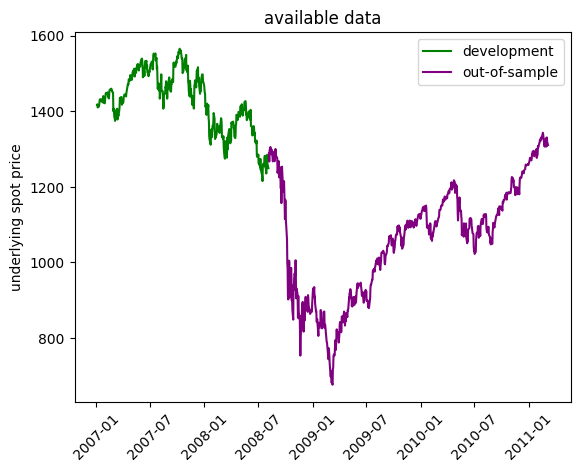

In [37]:
train_spots = train_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates().dropna()
test_spots = test_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates().dropna()
train_dates = pd.Series(train_spots.index)
test_dates = pd.Series(test_spots.index)
plt.figure()
plt.plot(train_spots,color='green',label='development')
plt.plot(test_spots,color='purple',label='out-of-sample')
plt.title('available data')
plt.ylabel('underlying spot price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 541/541 [00:00<00:00, 954.09it/s]


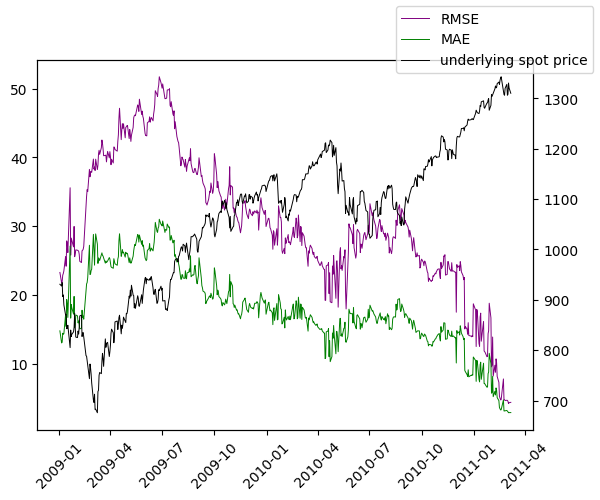

In [38]:
test_dates = test_dates[test_dates>pd.Timestamp(2009,1,1)]
MAES = pd.Series(np.tile(np.nan,len(test_dates)),index=test_dates)
RMSES = pd.Series(np.tile(np.nan,len(test_dates)),index=test_dates)
bar = tqdm(total = len(test_dates))
for date in test_dates:
    df = test_data[test_data['calculation_date']==date].set_index('calculation_date')
    prediction = df['outofsample_prediction']
    target = df['observed_price']
    diff = prediction - target
    RMSES[date] = np.sqrt(np.mean(diff**2))
    MAES[date] = np.mean(np.abs(diff))
    bar.update(1)
bar.close()

linew = 0.7
fig, ax1 = plt.subplots()
plt.xticks(rotation=45)
ax1.plot(RMSES,color='purple',label='RMSE',linewidth=linew)
ax1.plot(MAES,color='green',label='MAE',linewidth=linew)

ax2 = ax1.twinx()
ax2.plot(test_spots[test_spots.index.isin(test_dates)],color='black',label='underlying spot price',linewidth=linew)
fig.legend()
plt.show()

# In-depth testing